In [1]:
# import stuff that needed
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [2]:
# mount_drive coz the dataset is over there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# knobs for tweaking
BATCH_SIZE = 8
EPOCHS = 10
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224, 3)

In [4]:
# unzipping the dataset
import zipfile, os

local_zip = '/content/drive/MyDrive/Dataset/supermini.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
# preparing the data
base_dir = '/tmp/supermini'

#NUM_OF_CLASS = len(os.listdir(base_dir))

In [6]:
# data augmnentation
train_datagen  = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split = 0.2
)

In [7]:
# data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = IMG_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset = 'training'
)

test_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = IMG_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset = 'validation'
)

Found 204 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [8]:
# using Mobilnet for transfer learning
base_model = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"
feature_extractor = hub.KerasLayer(base_model, input_shape=(IMG_SHAPE), trainable=False, weights='imagenet')

In [9]:
# Add the custom classificiaton layer
model = Sequential([
            feature_extractor,
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
# compile the model
model.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.optimizers.RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

In [11]:
# training
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = test_generator,
    validation_steps = test_generator.n // BATCH_SIZE
)

Epoch 1/10
25/25 [==============================] - 50s 1s/step - loss: 0.7155 - accuracy: 0.7261 - val_loss: 0.2533 - val_accuracy: 0.9167
Epoch 2/10
25/25 [==============================] - 29s 1s/step - loss: 0.2220 - accuracy: 0.9157 - val_loss: 0.1945 - val_accuracy: 0.9375
Epoch 3/10
25/25 [==============================] - 29s 1s/step - loss: 0.2576 - accuracy: 0.9156 - val_loss: 0.0946 - val_accuracy: 0.9792
Epoch 4/10
25/25 [==============================] - 29s 1s/step - loss: 0.1747 - accuracy: 0.9134 - val_loss: 0.1477 - val_accuracy: 0.9375
Epoch 5/10
25/25 [==============================] - 29s 1s/step - loss: 0.2436 - accuracy: 0.9083 - val_loss: 0.0810 - val_accuracy: 0.9792
Epoch 6/10
25/25 [==============================] - 29s 1s/step - loss: 0.1528 - accuracy: 0.9442 - val_loss: 0.1283 - val_accuracy: 0.9375
Epoch 7/10
25/25 [==============================] - 29s 1s/step - loss: 0.1245 - accuracy: 0.9512 - val_loss: 0.1032 - val_accuracy: 0.9792
Epoch 8/10
25/25 [==

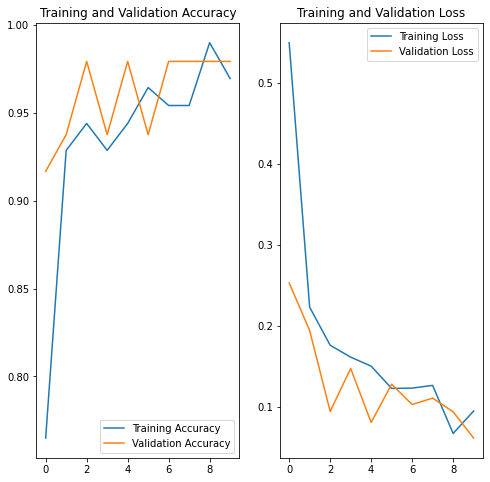

In [12]:
# plot train-test result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving jer9.jpg to jer9.jpg
jer9.jpg
Jeruk


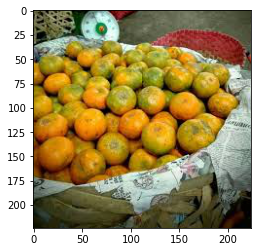

In [21]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg

uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=IMG_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('Appel')
  else:
    print('Jeruk')

In [25]:
saved_model = 'saved_model'
model.save(saved_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [26]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 93%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/variables/variables.index (deflated 75%)
  adding: content/saved_model/keras_metadata.pb (deflated 77%)
  adding: content/saved_model/assets/ (stored 0%)


In [31]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
model.save_weights("my_model_weights.h5")